# Demonstration of Timeseries forecasting 
**Using AWS GluonTS on Delhi pollution data**

*   Data source: https://www.airnow.gov/index.cfm?action=airnow.global_summary#India$New_Delhi
*   Tutorial on AWS GluonTS: https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series
*   We will use Amazon's GluonTS library to build a DeepAR Timeseries forecasting model. Unlike traidtional forecasting algorithms like ARMA, ARIMA, etc. DeepAR uses Recurrent Neural Networks (RNN) to build a deep learning model that reads multiple timeseries togather and builds a predictive model. DeepAR uses a combination of Long Short-term Memory (LSTM) units to capture longer periods of useful information from the timeseries and use this "Context" to make better predictions of the future. Here we apply this method to make predictions on pollution dataset for Delhi.

Author: Dattaraj Rao (dattarajrao@yahoo.com)

https://www.linkedin.com/in/dattarajrao/


In [28]:
# install gluonts using pip on command prompt
!pip install gluonts

Index(['Site', 'Parameter', 'Year', 'Month', 'Day', 'Hour', 'NowCast Conc.',
       'AQI', 'AQI Category', 'Raw Conc.', 'Conc. Unit', 'Duration',
       'QC Name'],
      dtype='object')
                     value  dependent1
Date (LT)                             
2019-01-01 01:00 AM    475       543.0
2019-01-01 02:00 AM    497       529.0
2019-01-01 03:00 AM    501       508.0
2019-01-01 04:00 AM    468       402.0
2019-01-01 05:00 AM    423       317.0
                     value  dependent1
Date (LT)                             
2019-05-31 08:00 PM    152        58.0
2019-05-31 09:00 PM    159        85.0
2019-05-31 10:00 PM    160        73.0
2019-05-31 11:00 PM    161        76.0
2019-06-01 12:00 AM    164        88.0


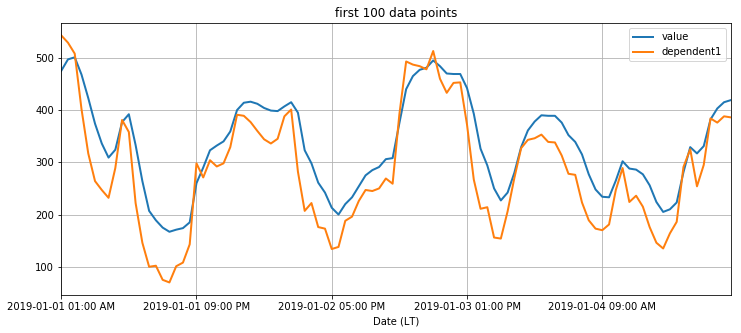

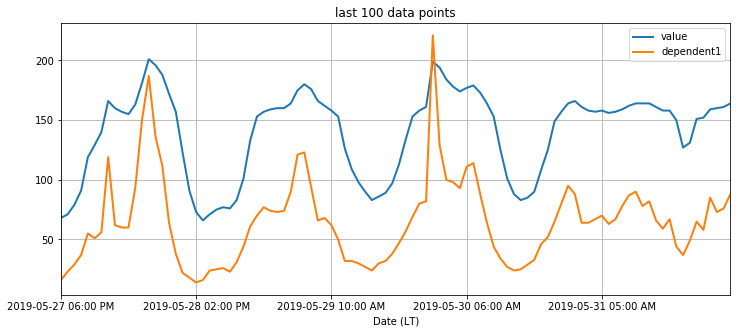

In [43]:
#download and visualize the data
import pandas as pd
import matplotlib.pyplot as plt

# download the dataset and load with date as index
url = "http://dosairnowdata.org/dos/historical/NewDelhi/2019/NewDelhi_PM2.5_2019_YTD.csv"
df = pd.read_csv(url, header=0, index_col=2)
print(df.columns)

# only use one column as the data
df = df[['AQI', 'Raw Conc.']]
df.columns = ["value",'dependent1']

# remove any negatives
df = df[df['value'] > 0]
df = df[df['dependent1'] < 1000]

# view the top and bottom 5 records
print(df.head(5))
print(df.tail(5))

# plot first 100 and last 100 points
df[:100].plot(figsize=(12, 5), linewidth=2, title="first 100 data points")
plt.grid()
plt.legend(df.columns)
plt.show()

df[-100:].plot(figsize=(12, 5), linewidth=2, title="last 100 data points")
plt.grid()
plt.legend(df.columns)
plt.show()

In [44]:
# train the model using gluonts
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(freq="1H", 
                            prediction_length=60, 
                            trainer=Trainer(epochs=10))

from gluonts.dataset.common import ListDataset

# set the seperation of training and testing values in timeseries
# beyond 29-04-01 01:00:00 will be used for testing and prior for training
# freq takes a pandas frequency for data - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2019-04-01 01:00 AM"]}],
    freq = "1H"
)

predictor = estimator.train(training_data=training_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.66it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[0] Elapsed time 21.501 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.412784
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.75it/s, avg_epoch_loss=4.59]
INFO:root:Epoch[1] Elapsed time 21.090 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.585370
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.70it/s, avg_epoch_loss=4.25]
INFO:root:Epoch[2] Elapsed time 21.300 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.246222
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:20<00:00,  4.77it/s, avg_epoch_loss=4.09]
INFO:root:Epoch[3] Elapsed time 20.961 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.094713
INFO:root:Epoch[4] Learning ra

In [0]:
# select 3 dates to do evaluation and draw charts for those
test_data = ListDataset(
    [
        {"start": df.index[0], "target": df.value[:"2019-04-10 01:00 AM"]},
        {"start": df.index[0], "target": df.value[:"2019-04-15 01:00 AM"]},
        {"start": df.index[0], "target": df.value[:"2019-04-20 01:00 AM"]}
    ],
    freq = "1H"
)

/usr/local/lib/python3.6/dist-packages/gluonts/evaluation/backtest.py:71: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  periods=data['target'].shape[-1],


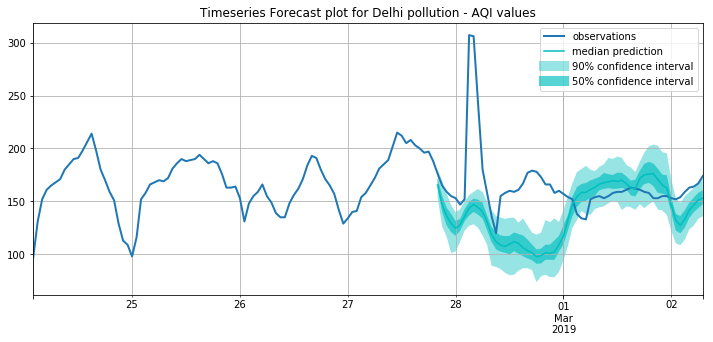

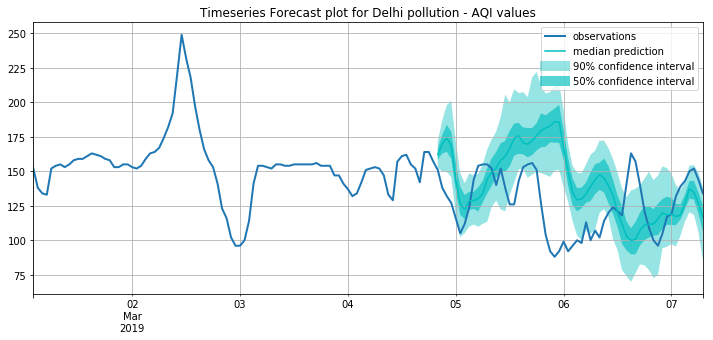

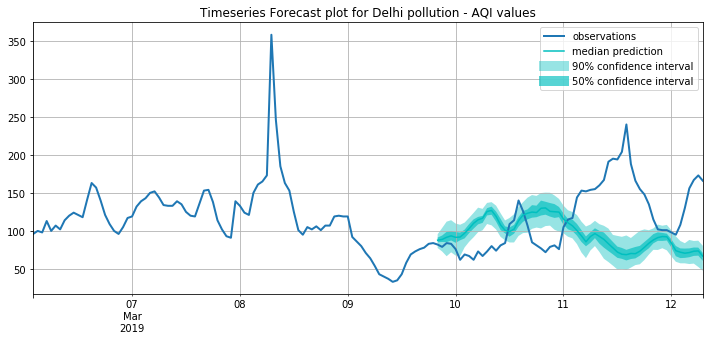

In [46]:
# plot the charts for predictions by gluonts
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2, title="Timeseries Forecast plot for Delhi pollution - AQI values")
        forecast.plot(color='c')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()
        
forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)